In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install livelossplot
%pylab inline
from livelossplot import PlotLosses
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import random
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
])

In [ ]:

class CustomImageDataset(VisionDataset):
    def __init__(self, root, transform=None, target_transform=None):
        super(CustomImageDataset, self).__init__(root, transform=transform, target_transform=target_transform)
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.imgs = [os.path.join(root, img) for img in os.listdir(root) if img.endswith('.jpeg')]
        self.labels = [self.assign_label(img) for img in self.imgs]

    def assign_label(self, filename):

        class_name = filename.split('_')[0]
        return class_name

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img_path = self.imgs[index]
        img = Image.open(img_path)

        label = self.labels[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label


In [ ]:
transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
])

folder_path = '/content/gdrive/MyDrive/real_hands'

In [ ]:
custom_dataset = CustomImageDataset(root=folder_path, transform=transform)

data_loader = DataLoader(custom_dataset, batch_size=64, shuffle=True)
images, labels =next(iter(data_loader))

In [ ]:
images[0].shape


torch.Size([1, 32, 32])

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, input_channels):
        super(SelfAttention, self).__init__()

        intermediate_channels = input_channels // 8

        self.f_transform = nn.Conv2d(input_channels, intermediate_channels, kernel_size=1)
        self.g_transform = nn.Conv2d(input_channels, intermediate_channels, kernel_size=1)
        self.h_transform = nn.Conv2d(input_channels, intermediate_channels, kernel_size=1)
        self.v_transform = nn.Conv2d(intermediate_channels, input_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        f = self.f_transform(x).view(batch_size, -1, width*height).permute(0, 2, 1)
        g = self.g_transform(x).view(batch_size, -1, width*height)
        h = self.h_transform(x).view(batch_size, -1, width*height)

        attention_map = torch.softmax(torch.matmul(f, g), dim=1)
        o = torch.matmul(attention_map, h.permute(0, 2, 1))
        o = o.permute(0, 2, 1).view(batch_size, -1, height, width)
        o = self.v_transform(o)
        o = self.gamma * o + x

        return o


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.attn1=SelfAttention(128)
        self.attn2=SelfAttention(64)
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            self.attn1,
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            self.attn2,
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.gen(noise.view(noise.size(0), noise.size(1), 1, 1))

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.attn1=SelfAttention(128)
        self.attn2=SelfAttention(256)

        self.disc = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.4, inplace=True),
            nn.Dropout2d(0.5),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.4, inplace=True),
            nn.Dropout2d(0.5),
            self.attn1,
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.4, inplace=True),
            self.attn2,
            nn.Flatten(),  # Flatten the output before the fully connected layer
            nn.Linear(256 * 4 * 4, 1),  # Adjust the input size to match the flattened output size
            nn.Sigmoid()
        )

    def forward(self, image):
        return self.disc(image)

In [ ]:
generator = Generator()

input_noise = torch.rand(1,100,1,1)

output_image = generator(input_noise)
print(output_image)
dis=Discriminator()
in_im=dis(output_image)
print(in_im)
#Attn=SelfAttention(1)
#Attn_map=Attn(output_image)
#print(Attn_map)

tensor([[[[-0.1328,  0.2940, -0.1486,  ..., -0.1612, -0.8272,  0.0520],
          [-0.5649, -0.8734,  0.4456,  ..., -0.0093, -0.0837,  0.2310],
          [-0.7493,  0.9461, -0.7902,  ..., -0.6501, -0.8639, -0.2920],
          ...,
          [-0.4273, -0.5438, -0.3523,  ..., -0.5827, -0.6219,  0.3288],
          [-0.7251, -0.7866, -0.9757,  ...,  0.5200, -0.9291, -0.2482],
          [-0.2567,  0.1335, -0.8784,  ...,  0.3118, -0.6635, -0.0819]]]],
       grad_fn=<TanhBackward0>)
tensor([[0.3581]], grad_fn=<SigmoidBackward0>)


In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss()
z_dim = 100
bs = 128
lambda_gp = 6
n_critic = 5

lr = 0.0003
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr,betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0009,betas=(0.5, 0.999))

In [ ]:
def D_train(x):
    D.train()
    D_optimizer.zero_grad()

    current_bs = x.size(0)
    x_real, y_real = x.view(-1, 1, 32, 32), torch.ones(current_bs, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    z = torch.randn(current_bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(current_bs, 1).to(device)

    D_output = D(x_fake.detach())
    D_fake_loss = criterion(D_output, y_fake)

    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return D_loss.data.item()

def G_train(x):
    G.train()
    G_optimizer.zero_grad()

    current_bs = x.size(0)
    z = torch.randn(bs, z_dim).to(device)
    y = torch.ones(bs, 1).to(device)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

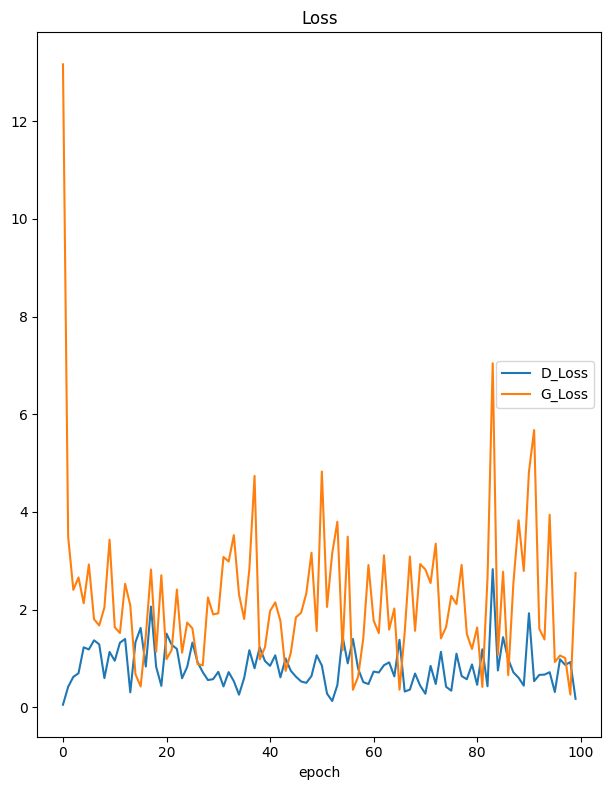

Loss
	D_Loss           	 (min:    0.050, max:    2.826, cur:    0.171)
	G_Loss           	 (min:    0.257, max:   13.167, cur:    2.749)


In [ ]:
n_epoch = 100
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(data_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

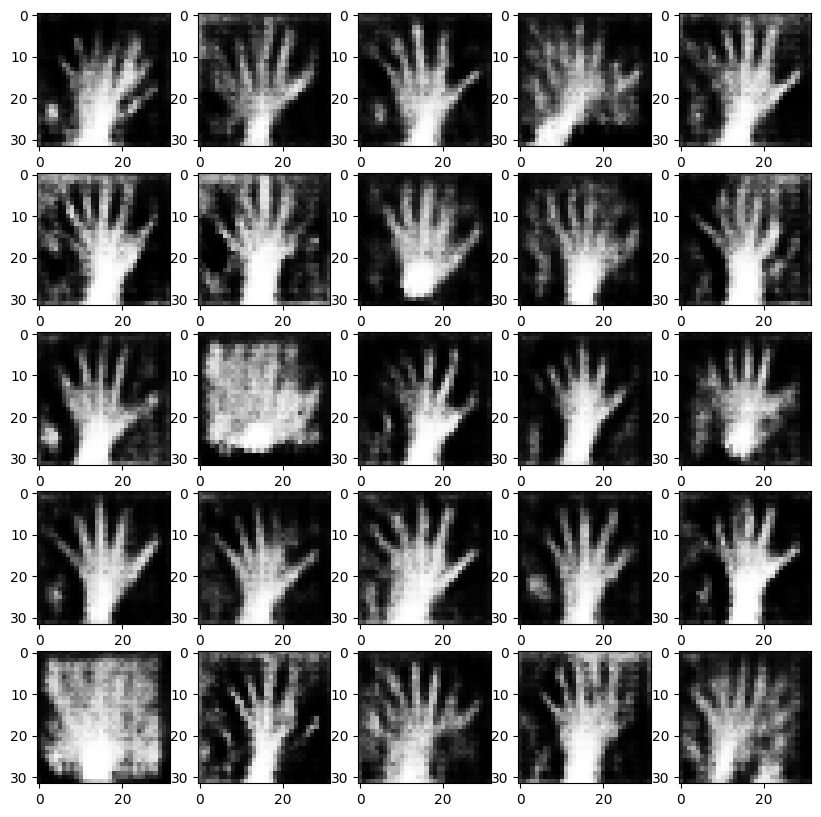

In [ ]:
#set_seed(0)

epoch = 20
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = torch.randn(bs, z_dim).to(device)
    generated = G(test_z)

fig, axarr = plt.subplots(5, 5, figsize=(10, 10))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
  ax.imshow(img, cmap="gray")

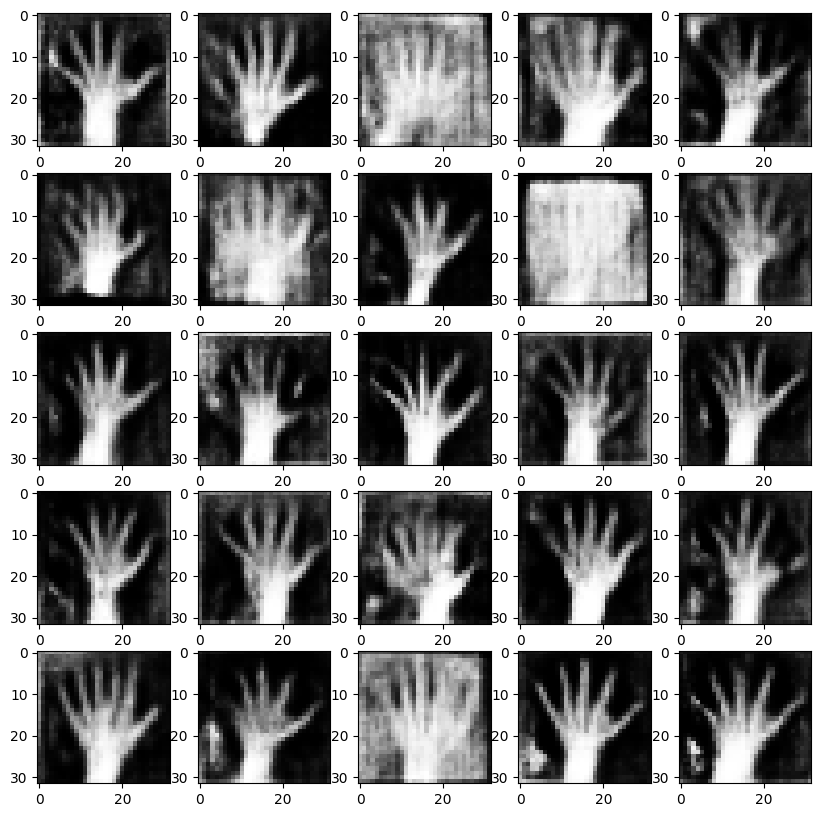

In [ ]:


epoch = 40
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = torch.randn(bs, z_dim).to(device)
    generated = G(test_z)

fig, axarr = plt.subplots(5, 5, figsize=(10, 10))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
  ax.imshow(img, cmap="gray")

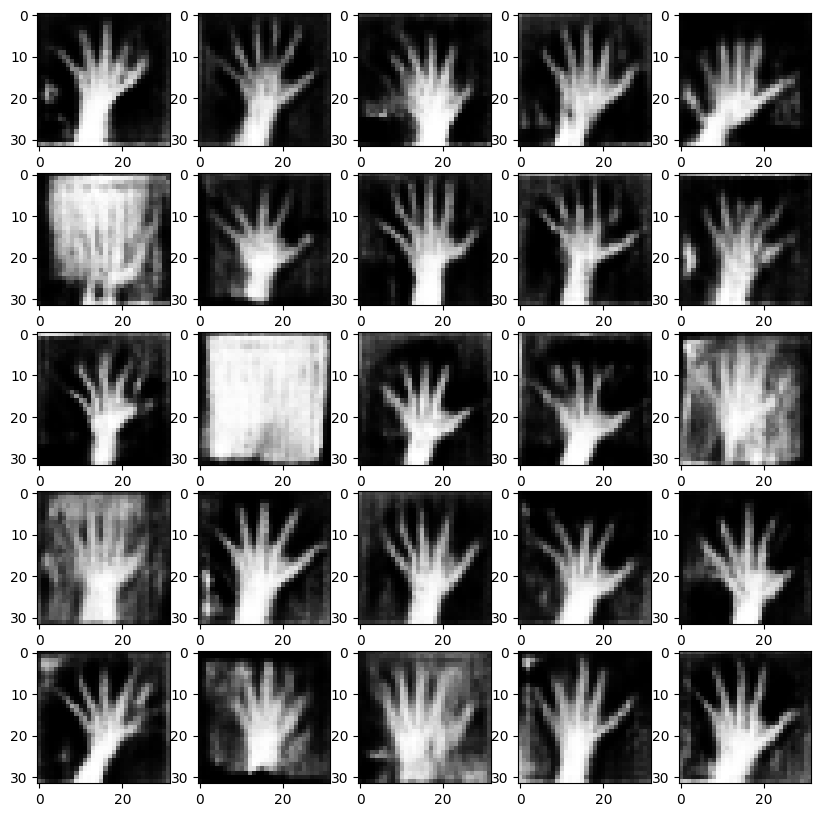

In [ ]:
epoch = 60
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = torch.randn(bs, z_dim).to(device)
    generated = G(test_z)

fig, axarr = plt.subplots(5, 5, figsize=(10, 10))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
  ax.imshow(img, cmap="gray")

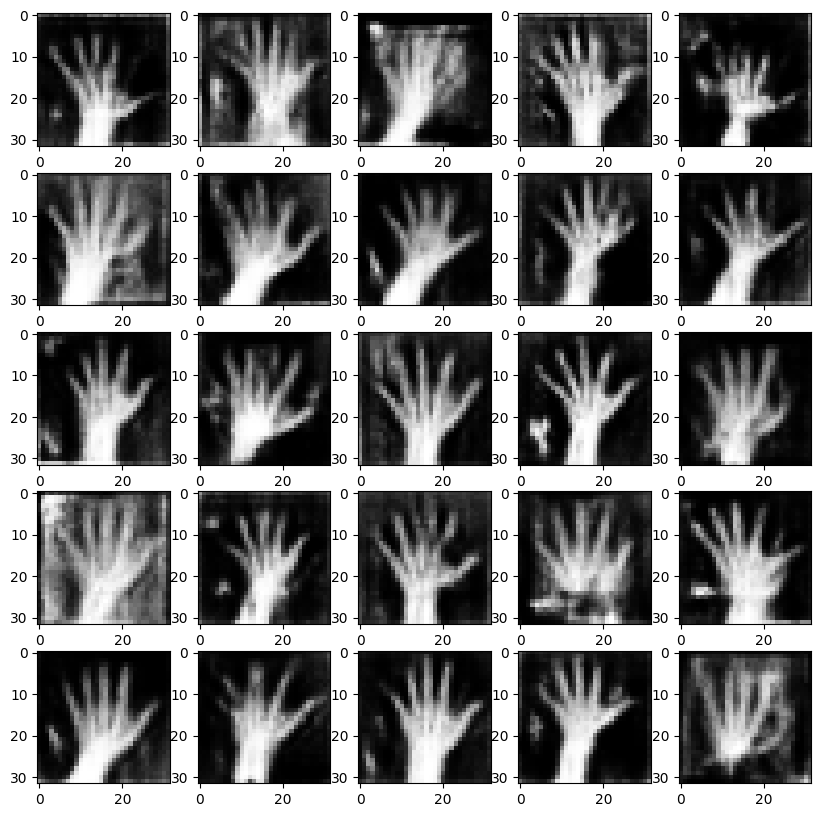

In [ ]:
epoch = 80
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = torch.randn(bs, z_dim).to(device)
    generated = G(test_z)

fig, axarr = plt.subplots(5, 5, figsize=(10, 10))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
  ax.imshow(img, cmap="gray")

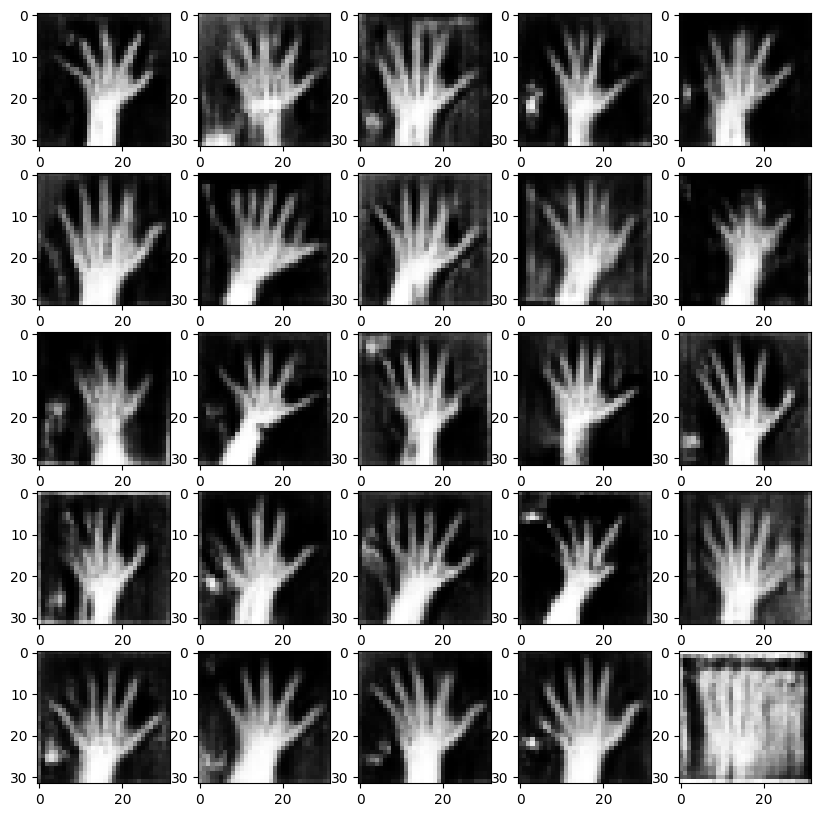

In [ ]:
epoch = 100
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = torch.randn(bs, z_dim).to(device)
    generated = G(test_z)


fig, axarr = plt.subplots(5, 5, figsize=(10, 10))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
  ax.imshow(img, cmap="gray")